In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-06g3tub5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-06g3tub5
  Resolved https://github.com/facebookresearch/detectron2.git to commit b7c7f4ba82192ff06f2bbb162b9f67b00ea55867
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


#importing libraries

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
from matplotlib import pyplot as plt
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train", {}, "/content/drive/MyDrive/Deep_Learning/Cell_detection/train/_annotations.coco.json", "/content/drive/MyDrive/Deep_Learning/Cell_detection/train")
register_coco_instances("dataset_val", {}, "/content/drive/MyDrive/Deep_Learning/Cell_detection/valid/_annotations.coco.json", "/content/drive/MyDrive/Deep_Learning/Cell_detection/valid")


In [5]:
train_metadata = MetadataCatalog.get("dataset_train")
train_dataset_dicts = DatasetCatalog.get("dataset_train") #gets information about the Annotations and images
val_metadata = MetadataCatalog.get("dataset_val")
val_dataset_dicts = DatasetCatalog.get("dataset_val")     #gets information about the Annotations and images

[04/04 14:03:25 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Deep_Learning/Cell_detection/train/_annotations.coco.json takes 3.31 seconds.
WARNING [04/04 14:03:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/04 14:03:25 d2.data.datasets.coco]: Loaded 383 images in COCO format from /content/drive/MyDrive/Deep_Learning/Cell_detection/train/_annotations.coco.json
WARNING [04/04 14:03:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/04 14:03:25 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/Deep_Learning/Cell_detection/valid/_annotations.coco.json


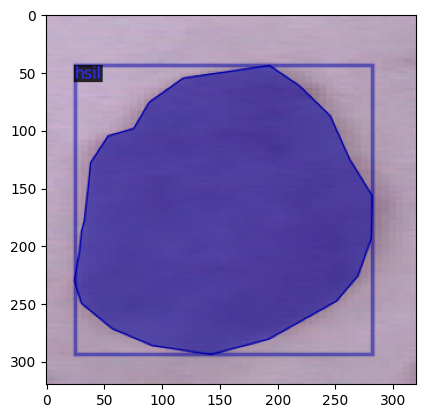

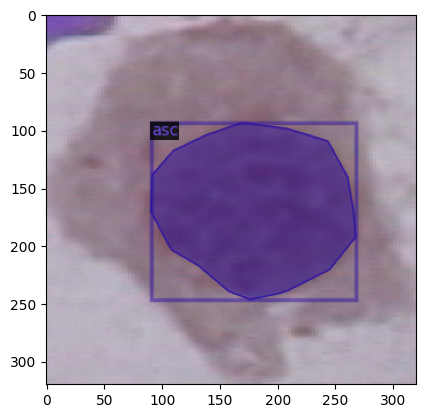

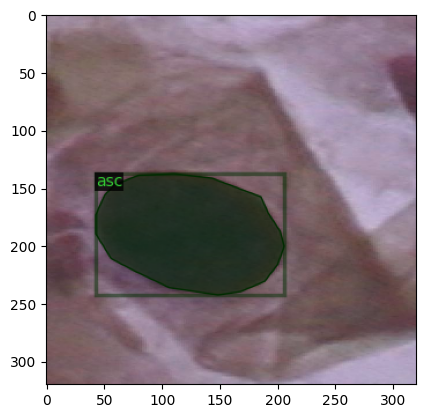

In [6]:
for sample in random.sample(train_dataset_dicts, 3):
  img = cv2.imread(sample["file_name"])
  vis = Visualizer(img[:, :, ::-1], metadata = train_metadata, scale = 0.5).draw_dataset_dict(sample)
  plt.imshow(vis.get_image()[:, :, ::-1])
  plt.show()

#Training

In [7]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is NOT available. Please enable GPU acceleration in the runtime settings.")

GPU is available.


In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # Adjust learning rate based on your dataset and model
cfg.SOLVER.MAX_ITER = 2000  # Increase maximum number of training iterations
cfg.SOLVER.STEPS = (800, 1600)  # Adjust steps for learning rate decay
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Number of classes excluding background
cfg.OUTPUT_DIR = '/content/drive/MyDrive/Deep_Learning/Cell_detection/Models'
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Set device to GPU if available

# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available



[04/04 14:03:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
R-50.pkl: 102MB [00:00, 104MB/s]                            


[04/04 14:03:31 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/04 14:03:31 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


In [9]:
trainer.train()

[04/04 14:03:31 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/04 14:04:08 d2.utils.events]:  eta: 0:21:33  iter: 19  total_loss: 3.413  loss_cls: 2.013  loss_box_reg: 0.01236  loss_mask: 0.692  loss_rpn_cls: 0.6852  loss_rpn_loc: 0.008567    time: 1.4439  last_time: 0.6597  data_time: 0.7752  last_data_time: 0.0093   lr: 2.881e-06  max_mem: 3094M
[04/04 14:04:24 d2.utils.events]:  eta: 0:21:10  iter: 39  total_loss: 2.776  loss_cls: 1.357  loss_box_reg: 0.01491  loss_mask: 0.6919  loss_rpn_cls: 0.6819  loss_rpn_loc: 0.01064    time: 1.0137  last_time: 0.5851  data_time: 0.0127  last_data_time: 0.0106   lr: 4.861e-06  max_mem: 3097M
[04/04 14:04:37 d2.utils.events]:  eta: 0:20:57  iter: 59  total_loss: 2.039  loss_cls: 0.6298  loss_box_reg: 0.02858  loss_mask: 0.6915  loss_rpn_cls: 0.6738  loss_rpn_loc: 0.009228    time: 0.8836  last_time: 0.6360  data_time: 0.0141  last_data_time: 0.0103   lr: 6.841e-06  max_mem: 3097M
[04/04 14:04:50 d2.utils.events]:  eta: 0:20:44  iter: 79  total_loss: 1.758  loss_cls: 0.3397  loss_box_reg: 0.04406  loss_m

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
import yaml
import os
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/Deep_Learning/Cell_detection/Models/config-5k_iter.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

#Save the model weights with a different name so we don't accidentally overwrite our model.
os.rename(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"), os.path.join(cfg.OUTPUT_DIR, "model_10k_iter.pth"))


In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_10k_iter.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom threshold
predictor = DefaultPredictor(cfg)

[04/04 14:27:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Deep_Learning/Cell_detection/Models/model_10k_iter.pth ...


#TEST

In [12]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_test", {}, "/content/drive/MyDrive/Deep_Learning/Cell_detection/test/_annotations.coco.json", "/content/drive/MyDrive/Deep_Learning/Cell_detection/test")
test_metadata = MetadataCatalog.get("dataset_test")
test_dataset_dicts = DatasetCatalog.get("dataset_test")

WARNING [04/04 14:27:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/04 14:27:58 d2.data.datasets.coco]: Loaded 54 images in COCO format from /content/drive/MyDrive/Deep_Learning/Cell_detection/test/_annotations.coco.json


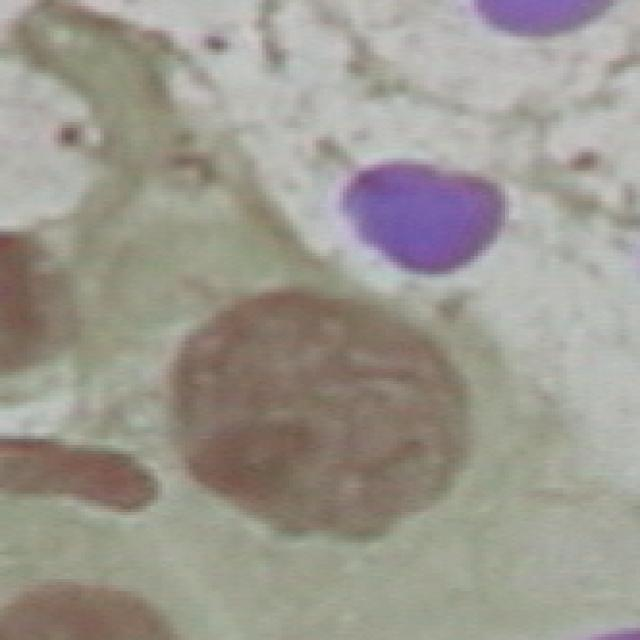

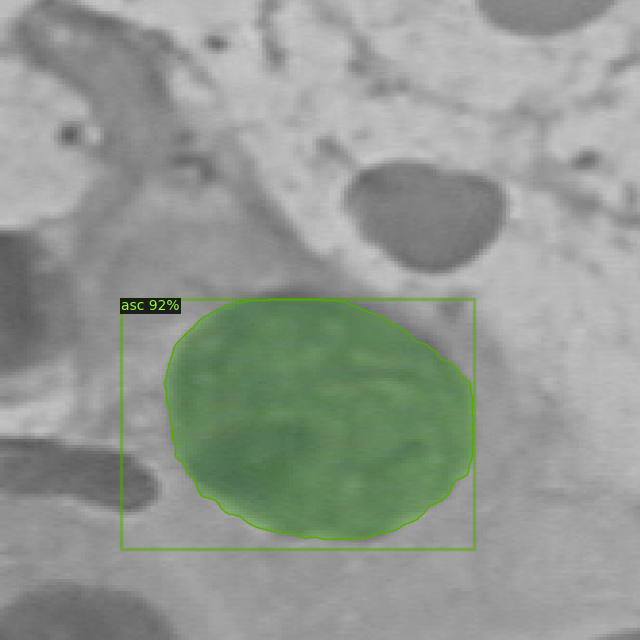

In [13]:
from detectron2.utils.visualizer import ColorMode

for sample in random.sample(test_dataset_dicts, 1):    #select number of images for display
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata = test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(img[:, :, ::-1])
    cv2_imshow(out.get_image()[:, :, ::-1])

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("dataset_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "dataset_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))

WARNING [04/04 14:27:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/04 14:27:59 d2.data.datasets.coco]: Loaded 54 images in COCO format from /content/drive/MyDrive/Deep_Learning/Cell_detection/test/_annotations.coco.json
[04/04 14:27:59 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    cell    | 0            |    asc     | 18           |    hsil    | 12           |
|    lsil    | 16           | normal-he  | 9            | normal-mo  | 8            |
|            |              |            |              |            |              |
|   total    | 63           |            |              |            |              |
[04/04 14:27:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEd

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[04/04 14:28:01 d2.evaluation.evaluator]: Inference done 11/54. Dataloading: 0.0036 s/iter. Inference: 0.1132 s/iter. Eval: 0.0049 s/iter. Total: 0.1217 s/iter. ETA=0:00:05
[04/04 14:28:05 d2.evaluation.evaluator]: Total inference time: 0:00:05.148372 (0.105069 s / iter per device, on 1 devices)
[04/04 14:28:05 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:04 (0.088838 s / iter per device, on 1 devices)
[04/04 14:28:05 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/04 14:28:05 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/04 14:28:05 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[04/04 14:28:05 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/04 14:28:05 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.02 seconds.
[04/04 14:28:05 d2.evaluation.

#load and checking a random image


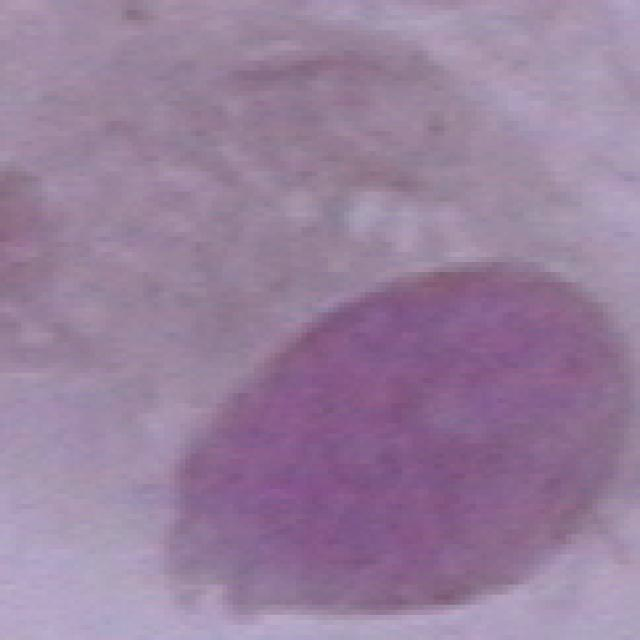

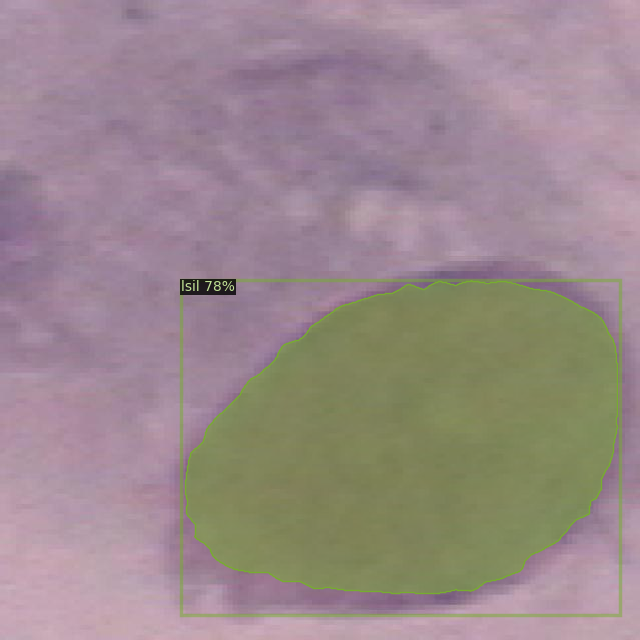

In [18]:
new_img = cv2.imread("/content/drive/MyDrive/Deep_Learning/Cell_detection/test/153276386-153276414-001_BMP.rf.9748dde3842a34f2ef4dea354b75d22c.jpg")
outputs  = predictor(new_img)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_img[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(new_img[:, :, ::-1])
cv2_imshow(out.get_image()[:, :, ::-1])

In [16]:
# Commenting the following code as we often do not need to save segmented images with bounding boxes.
# We need real numbers with object measurements or labeled images as output.


# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/Deep_Learning/Cell_detection/train"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/Deep_Learning/Cell_detection/output"

# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    # Check if the file has a valid image extension
    if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")

Segmentation of all images completed.
